# 최종신용점수 등급화

이지은

#### 맨 마지막에 [7. '최종신용점수'로 등급 재분류]만 보시면 됩니다!

- 최종신용점수 기준점 정하기 -> Decision Tree(결정트리) modeling 사용
- 기준점대로 등급 부여
- 이전 등급 분포와의 분포 차이 확인

In [1]:
# 라이브러리 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

C:\Users\LG\AppData\Local\Temp\ipykernel_9700\2478983249.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# 한글 깨짐 해결
# 출처: https://giveme-happyending.tistory.com/168 [소연의_개발일지:티스토리]
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 1. 데이터 불러오기

In [3]:
train_df = pd.read_csv('css/train.csv')
test_df = pd.read_csv('css/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


## 2. 데이터 전처리

### (1) 데이터 바꾸기, 컬럼 삭제하기

In [4]:
# 대출기간 전처리 (int로 바꾸기)
def get_loan_month(mt):
    return int(mt.strip().replace('months', ''))

train_df['대출기간'] = train_df['대출기간'].apply(get_loan_month)
train_df[['대출기간']]

# 근로기간 전처리 (0, 1, 2, ..., 10 (int), unknown은 nan 대체)
def get_work_year(yr):
    if yr in ['<1 year', '< 1 year']:
        return 0
    elif yr in ['1 year', '1 years']:
        return 1
    elif yr in ['10+ years', '10+years']:
        return 10
    # 'Unknown'은 NaN으로 대체
    elif yr == 'Unknown':
        return np.nan
    # 그 외는 숫자만 추출
    else:
        return int(''.join(filter(str.isdigit, yr)))

train_df['근로기간'] = train_df['근로기간'].apply(get_work_year)
train_df[['근로기간']]

# ID 컬럼 drop
train_df = train_df.drop(labels='ID', axis=1)

# 부채_대비_소득_비율 9999 drop
train_df = train_df.drop(train_df[train_df['부채_대비_소득_비율']==9999].index)

### (2) 필요한 데이터 추가하기

In [5]:
def get_plus_col(df):
    df['상환부담율'] = df['총상환이자'] / df['대출금액'] * 100
    df['상환율'] = df['총상환원금'] / df['대출금액'] * 100

get_plus_col(train_df)
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.000000,0.00000
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,1.625417,2.59425
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,1.266200,7.73870


### (3) 대출등급 A~G -> 6~0

In [6]:
def get_grade_to_num(x):
    if x == 'A': return 6
    if x == 'B': return 5
    if x == 'C': return 4
    if x == 'D': return 3
    if x == 'E': return 2
    if x == 'F': return 1
    if x == 'G': return 0

train_df['대출등급'] = train_df['대출등급'].apply(get_grade_to_num)
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,4,0.000000,0.00000
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,5,1.625417,2.59425
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,6,1.266200,7.73870


### (4) 상환부담율, 상환율 로그 정규화 시켜주기

In [7]:
# 로그 정규화
def log_normalize(data):
    return np.log(data + 1)  # 0이거나 음수인 경우를 방지하기 위해 1을 더해줍니다.

# 상환부담율과 상환율을 로그 정규화
train_df['로그_상환부담율'] = log_normalize(train_df['상환부담율'])
train_df['로그_상환율'] = log_normalize(train_df['상환율'])

train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,로그_상환부담율,로그_상환율
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,4,0.000000,0.00000,0.000000,0.000000
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,5,1.625417,2.59425,0.965240,1.279335
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,6,1.266200,7.73870,0.818104,2.167761


## 3. 모델링

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [9]:
def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') 
    # 각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ':', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

### (1) RF (RandomForest)

In [10]:
# RF modeling -> 중요변수 찾아서 acc, f1-score 구하기
model_rf = RandomForestClassifier()

X_features = ['로그_상환부담율', '로그_상환율']

X = train_df[X_features]
y = train_df['대출등급']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

model_rf.fit(X_train, y_train)
y_rf_pred = model_rf.predict(X_test)

get_score('rf', y_test, y_rf_pred)

rf : acc 스코어:  0.9492176682359457 , f1 스코어:  0.9497259464795202


### (2) LR (Linear Regression)

In [11]:
# LR modeling -> 가중치, 편향 구하고 신용점수 선형방정식 만들기 
from sklearn.linear_model import LinearRegression

X = train_df[['로그_상환부담율', '로그_상환율']]
y = train_df[['대출등급']]

model = LinearRegression()
model.fit(X, y)

lr_coef = model.coef_
lr_intercept = model.intercept_

# print(lr_coef)
# print(lr_intercept)

w1 = lr_coef[0][0].round(2)
w2 = lr_coef[0][1].round(2)
interc_rnd = lr_intercept[0].round(2)

print(w1, w2, interc_rnd)
print("lr 신용 점수 =", "상환부담율 *", w1, "+", "상환율 *", w2, "+", interc_rnd)

-2.58 1.72 4.34
lr 신용 점수 = 상환부담율 * -2.58 + 상환율 * 1.72 + 4.34


## 4. 신용점수 산출하기

In [12]:
train_df['신용점수'] = (train_df['로그_상환부담율'] * (-2.58)) + (train_df['로그_상환율'] * 1.72) + 4.34
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,로그_상환부담율,로그_상환율,신용점수
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,4,0.000000,0.00000,0.000000,0.000000,4.340000
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,5,1.625417,2.59425,0.965240,1.279335,4.050139
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,6,1.266200,7.73870,0.818104,2.167761,5.957840


## 5. 스케일링 (1~1000)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# 범위(0~1000) 설정
mnmx_scaler = MinMaxScaler(feature_range=(0, 1000))  

train_df['최종신용점수'] = mnmx_scaler.fit_transform(train_df[['신용점수']])
train_df.describe()

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,로그_상환부담율,로그_상환율,신용점수,최종신용점수
count,9.629300e+04,96293.000000,90623.000000,9.629300e+04,96293.000000,96293.000000,96293.000000,9.629300e+04,9.629300e+04,96293.000000,96293.000000,96293.000000,96293.000000,96293.000000,96293.000000,96293.000000,96293.000000,96293.000000
mean,1.830414e+07,43.929548,6.007791,9.392770e+07,19.275952,25.304882,0.345664,8.225099e+05,4.282318e+05,54.381149,0.005805,4.277871,2.256616,4.784138,1.068651,1.564607,4.274004,377.468618
std,1.032903e+07,11.288611,3.728511,9.956877e+07,9.624810,12.088616,0.919108,1.027749e+06,4.402120e+05,1414.776554,0.079967,1.270967,1.554905,4.785389,0.482246,0.627441,1.015325,80.145526
min,1.200000e+06,36.000000,0.000000,1.440000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.507965,0.000000
25%,1.020000e+07,36.000000,2.000000,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000,4.000000,1.084133,2.349312,0.734353,1.208755,3.630623,326.682843
50%,1.680000e+07,36.000000,6.000000,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870160e+05,0.000000,0.000000,4.000000,1.949167,4.367333,1.081523,1.680331,4.340000,382.678057
75%,2.400000e+07,60.000000,10.000000,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702280e+05,0.000000,0.000000,5.000000,3.098750,6.964000,1.410682,2.074931,4.988783,433.890290
max,4.200000e+07,60.000000,10.000000,1.080000e+10,1092.520000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000,6.000000,18.146637,100.000000,2.952127,4.615121,12.160556,1000.000000


In [14]:
train_df['최종신용점수'].describe()

count    96293.000000
mean       377.468618
std         80.145526
min          0.000000
25%        326.682843
50%        382.678057
75%        433.890290
max       1000.000000
Name: 최종신용점수, dtype: float64

## 6. 최종신용점수

<Axes: xlabel='대출등급', ylabel='최종신용점수'>

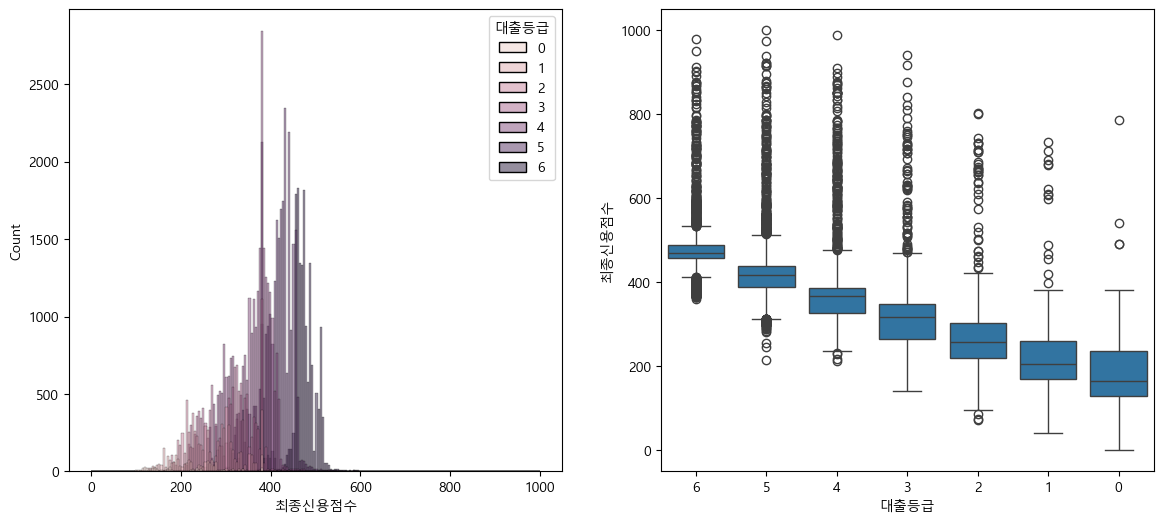

In [15]:
hue_order = ['6', '5', '4', '3', '2', '1', '0']

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train_df, x='최종신용점수', hue='대출등급', ax=ax[0])
sns.boxplot(data=train_df, y='최종신용점수', x='대출등급', order=hue_order, ax=ax[1])

## 7. '최종신용점수'로 등급 재분류

#### (1) 신용점수 기준점 정하기

##### DT (Decision Tree) 
- 기준점 정할 때 결정트리 사용

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

In [17]:
# DT(Decision Tree) modeling

# X, y 정의
X = train_df[['최종신용점수']]
y = train_df['대출등급']

# train / test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, stratify=y, random_state = 42)

# 의사결정 나무 모델 만들기
model_dt = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7)
# max_depth=3 -> 트리 가지치기를 3번 진행하면 마지막 리프 노트가 8개 나옴 (우리 대출등급은 총 7개라서)
# max_leaf_nodes=7 -> 대출등급이 7개라서 설정함

# train 데이터 훈련
model_dt.fit(X_train, y_train)

# feature importances
print(model_dt.feature_importances_)

# 평가 점수 출력
print("Train Set Score1 : {:.2f}".format(model_dt.score(X_train, y_train)))
print("Test  Set Score1 : {:.2f}".format(model_dt.score(X_test, y_test)))

[1.]
Train Set Score1 : 0.61
Test  Set Score1 : 0.61


In [18]:
# 결정트리 노드 나누는 기준 text로 볼 수 있는 코드
model_dt_text = tree.export_text(model_dt)
print(model_dt_text)

|--- feature_0 <= 456.88
|   |--- feature_0 <= 405.81
|   |   |--- feature_0 <= 271.11
|   |   |   |--- class: 3
|   |   |--- feature_0 >  271.11
|   |   |   |--- class: 4
|   |--- feature_0 >  405.81
|   |   |--- feature_0 <= 451.91
|   |   |   |--- class: 5
|   |   |--- feature_0 >  451.91
|   |   |   |--- class: 5
|--- feature_0 >  456.88
|   |--- feature_0 <= 534.95
|   |   |--- feature_0 <= 459.39
|   |   |   |--- class: 6
|   |   |--- feature_0 >  459.39
|   |   |   |--- class: 6
|   |--- feature_0 >  534.95
|   |   |--- class: 6



- 결정트리 시각화
    - Matplotlib
    - Graphviz : 설치가 안되어 있으면 에러날 수 있음 -> 설치 참고 게시글 : https://free-eunb.tistory.com/14

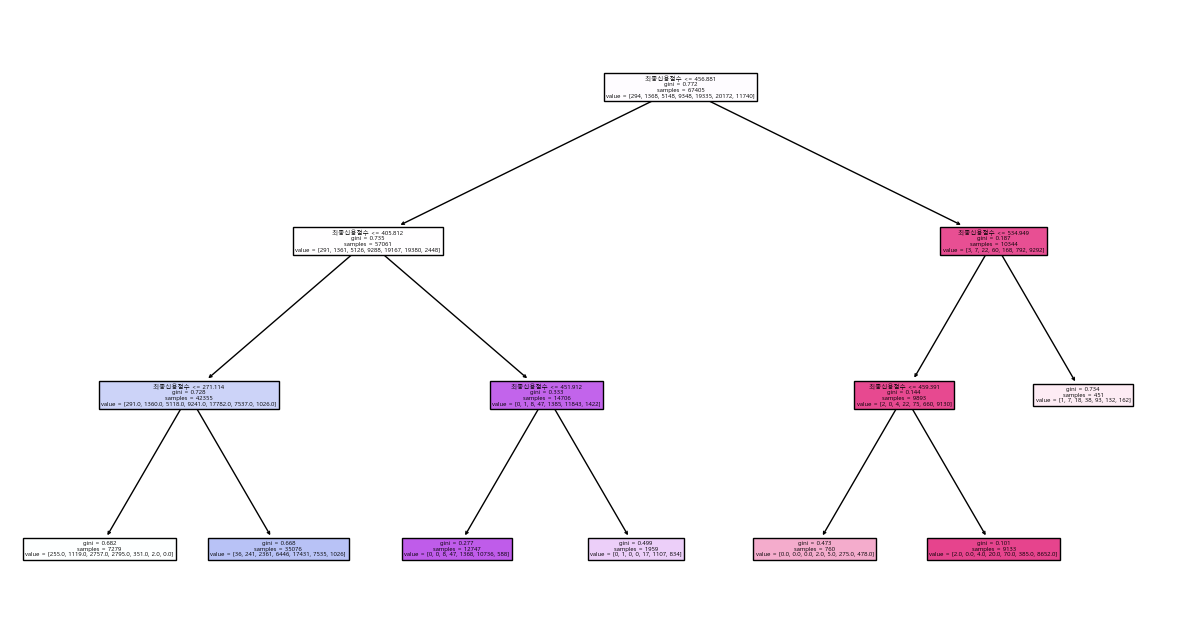

In [19]:
# 의사결정나무 시각화 (Matplotlib)
fig = plt.figure(figsize=(15, 8))
dt_viz = tree.plot_tree(model_dt, 
                  feature_names=['최종신용점수'],
                  filled=True)

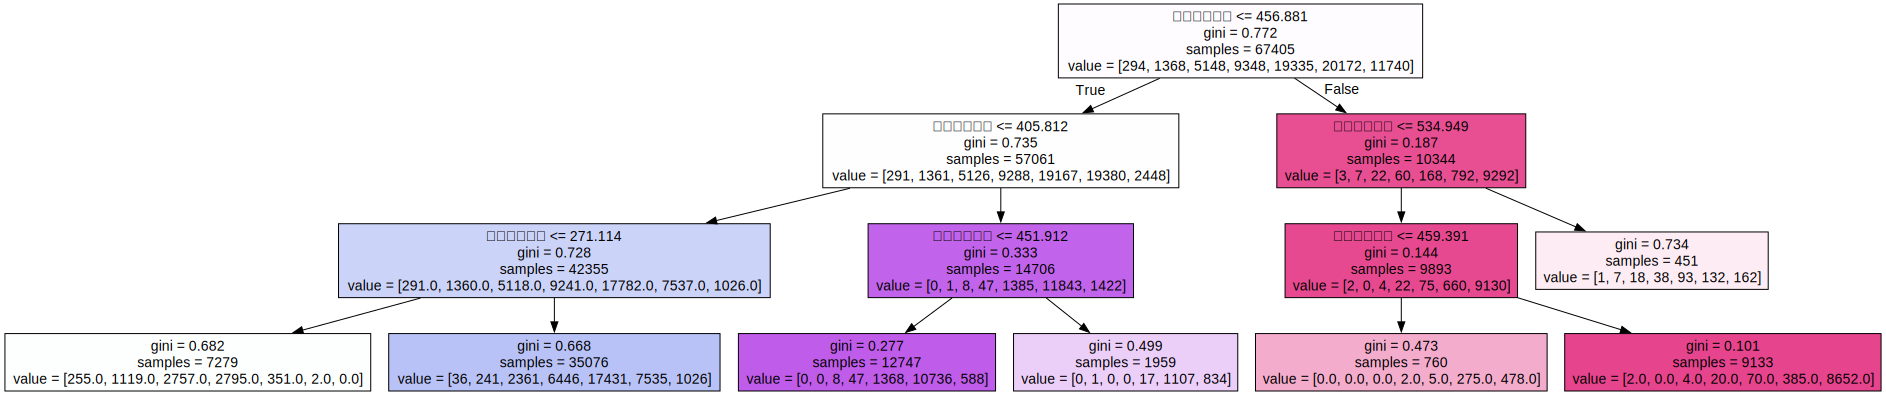

In [20]:
import graphviz

# 의사결정나무 시각화 (Graphviz)
tree_dot = export_graphviz(model_dt,
                           feature_names=['최종신용평가'],
                           filled=True)

dt_graph = graphviz.Source(tree_dot, format='png')
dt_graph

### (2) 등급 재분류

#### 기준점 정리

- A등급 : 534.949 이상
- B등급 : 459.391 이상 534.949 미만
- C등급 : 456.881 이상 459.391 미만
- D등급 : 451.912 이상 456.881 미만
- E등급 : 405.812 이상 451.912 미만
- F등급 : 271.114 이상 405.812 미만
- G등급 : 271.114 미만

In [21]:
# 신용점수 등급 재분류 함수
def get_new_grade(x):
    if x >= 534.949:
        return 'A'
    elif x >= 459.391 and x < 534.949:
        return 'B'
    elif x >= 456.881 and x < 459.391:
        return 'C'
    elif x >= 451.912 and x < 456.881:
        return 'D'
    elif x >= 405.812 and x < 451.912:
        return 'E'
    elif x >= 271.114 and x < 405.812:
        return 'F'
    else:
        return 'G'

In [22]:
# 등급재분류 컬럼이름 -> [신_대출등급]  탄생!!
train_df['신_대출등급'] = train_df['최종신용점수'].apply(get_new_grade)
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,...,총연체금액,연체계좌수,대출등급,상환부담율,상환율,로그_상환부담율,로그_상환율,신용점수,최종신용점수,신_대출등급
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,...,0.0,0.0,4,0.000000,0.00000,0.000000,0.000000,4.340000,382.678057,F
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,...,0.0,0.0,5,1.625417,2.59425,0.965240,1.279335,4.050139,359.797610,F
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,...,0.0,0.0,6,1.266200,7.73870,0.818104,2.167761,5.957840,510.383601,B


In [31]:
train_df['신_대출등급'].value_counts().sort_index()

신_대출등급
A      630
B    13000
C     1077
D     2842
E    18275
F    50015
G    10454
Name: count, dtype: int64

In [32]:
# 각 등급 별 상대빈도
# 전체데이터 중 해당 등급 데이터 수의 비율
train_df['신_대출등급'].value_counts(normalize=True).sort_index()

신_대출등급
A    0.006543
B    0.135005
C    0.011185
D    0.029514
E    0.189785
F    0.519404
G    0.108564
Name: proportion, dtype: float64

In [34]:
# 각 등급 별 상대빈도를 퍼센트로 나타내봄
new_grade_ratio = train_df['신_대출등급'].value_counts(normalize=True).sort_index()
new_grade_ratio = new_grade_ratio * 100
new_grade_ratio

신_대출등급
A     0.654253
B    13.500462
C     1.118461
D     2.951409
E    18.978534
F    51.940432
G    10.856449
Name: proportion, dtype: float64

### (3) 이전 대출등급과 신대출등급의 분포 차이

In [47]:
import numpy as np

C:\Users\LG\AppData\Local\Temp\ipykernel_9700\2135951545.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_df, x='대출등급', order=hue_order1, ax=ax[0], palette='Set3').set_title('대출등급 분포')
C:\Users\LG\AppData\Local\Temp\ipykernel_9700\2135951545.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_df, x='신_대출등급', order=hue_order2, ax=ax[1], palette='Set3').set_title('신_대출등급 분포')


Text(0.5, 1.0, '신_대출등급 분포')

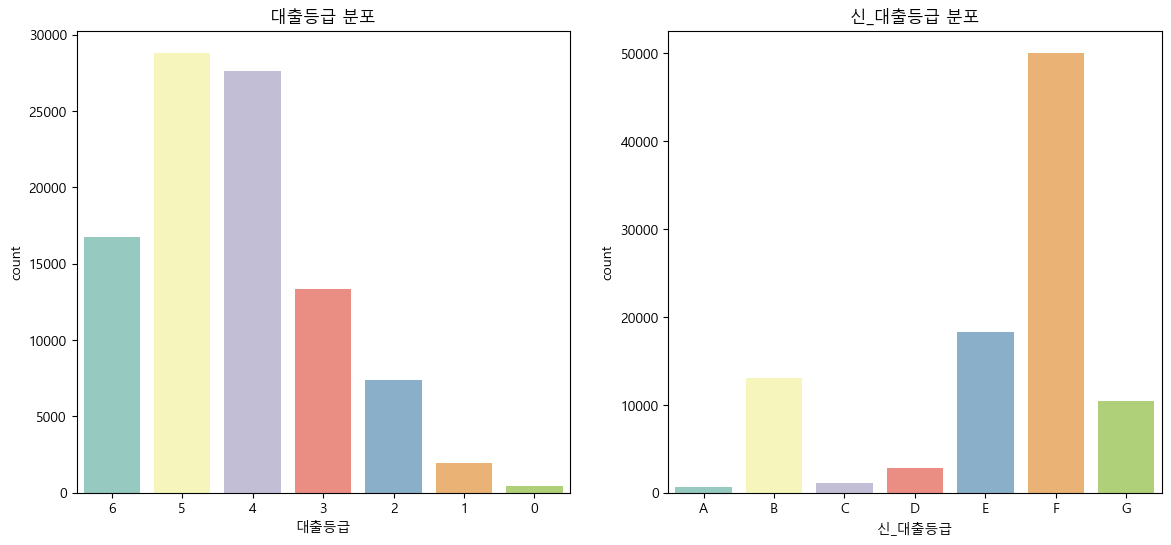

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

hue_order1 = ['6', '5', '4', '3', '2', '1', '0']
hue_order2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(train_df, x='대출등급', order=hue_order1, ax=ax[0], palette='Set3').set_title('대출등급 분포')
sns.countplot(train_df, x='신_대출등급', order=hue_order2, ax=ax[1], palette='Set3').set_title('신_대출등급 분포')

C:\Users\LG\AppData\Local\Temp\ipykernel_9700\2042686273.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_df, x='대출등급',order=hue_order1 ,palette='Set3').set_title('대출등급 분포')


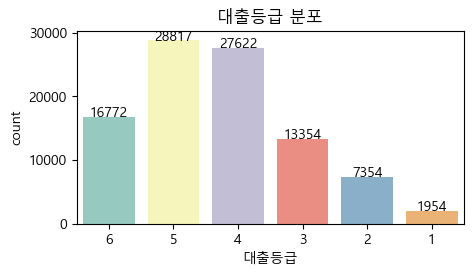

In [53]:
# 대출등급 분포
fig, ax = plt.subplots(figsize=(5,2.5))

hue_order1 = [6,5,4,3,2,1]
sns.countplot(train_df, x='대출등급',order=hue_order1 ,palette='Set3').set_title('대출등급 분포')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2), # 가로 위치
            p.get_y() + p.get_height(),  # 세로 위치
            f"{p.get_height():.0f}",  # 값 + 표시방법(소수 둘째자리까지)
            ha = 'center')  # 좌우 정렬 중간으로

C:\Users\LG\AppData\Local\Temp\ipykernel_9700\295825537.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_df, x='신_대출등급',order=hue_order2 ,palette='Set3').set_title('대출등급 분포')


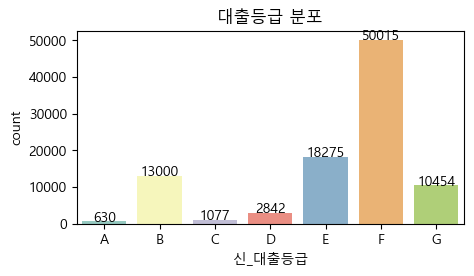

In [52]:
# 신_대출등급 분포
fig, ax = plt.subplots(figsize=(5,2.5))

hue_order2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(train_df, x='신_대출등급',order=hue_order2 ,palette='Set3').set_title('대출등급 분포')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2), # 가로 위치
            p.get_y() + p.get_height(),  # 세로 위치
            f"{p.get_height():.0f}",  # 값 + 표시방법(소수 둘째자리까지)
            ha = 'center')  # 좌우 정렬 중간으로